# **Data-driven collective variables for enhanced sampling** - Training

This notebook contains the code used in the paper "Data-driven collective variables for enhanced sampling" by Bonati, Rizzi and Parrinello (2019).

# Setup and methods

### Modules

In [0]:
!pip3 install torch==1.1.0 torchvision==0.3.0 -f https://download.pytorch.org/whl/torch_stable.html

In [0]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

In [0]:
import os
import numpy as np
import scipy 
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import progressbar

### Palette

In [0]:
###################################################################
# Fessa palette for python matplotlib
###################################################################
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

def hex_to_rgb(value):
    value = value.lstrip('#')
    lv = len(value)
    rgb=tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))
    return tuple([x/255. for x in rgb])


paletteFessa = [
          hex_to_rgb("#1F3B73"),
          hex_to_rgb("#2F9294"),
          hex_to_rgb("#50B28D"),
          hex_to_rgb("#A7D655"),
          hex_to_rgb("#FFE03E"),
          hex_to_rgb("#FFA955"),
          hex_to_rgb("#D6573B")
         ]

cm_fessa = LinearSegmentedColormap.from_list("fessa", paletteFessa, N=1000)

matplotlib.colors.ColorConverter.colors['fessa1'] = paletteFessa[0]
matplotlib.colors.ColorConverter.colors['fessa2'] = paletteFessa[1]
matplotlib.colors.ColorConverter.colors['fessa3'] = paletteFessa[2]
matplotlib.colors.ColorConverter.colors['fessa4'] = paletteFessa[3]
matplotlib.colors.ColorConverter.colors['fessa5'] = paletteFessa[4]
matplotlib.colors.ColorConverter.colors['fessa6'] = paletteFessa[5]
matplotlib.colors.ColorConverter.colors['fessa7'] = paletteFessa[6]

fessaNames=['fessa1', 'fessa2' , 'fessa3', 'fessa4', 
              'fessa5', 'fessa6' , 'fessa7']

# Usage examples
# For contour plots
# plt.contourf(X,Y,Z,cmap=cm_fessa)
# For standard plots
# plt.plot(x,y,color=paletteFessa[0])
# or
# plt.plot(x,y,color='fessa1')

## Datasets

In [0]:
class ColvarDataset(Dataset):
    """COLVAR dataset"""

    def __init__(self, colvar_list):
        self.nstates = len( colvar_list )
        self.colvar = colvar_list
        
    def __len__(self):
        return len(self.colvar[0])

    def __getitem__(self, idx):
        x = ()
        for i in range(self.nstates):
            x += (self.colvar[i][idx],)
        return x
    
#useful for cycling over the test dataset even if it is smaller than the training set
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

## NN architecture

In [0]:
##################################
# Define Networks
##################################

class NN_DeepLDA(nn.Module):
    
    def __init__(self, l ):
        super(NN_DeepLDA, self).__init__()
        
        #Encoder architecture
        modules=[]
        for i in range( len(l)-1 ):
            print(l[i],' --> ', l[i+1], end=' ')
            if( i<len(l)-2 ):
                modules.append(nn.Linear(l[i], l[i+1]) )
                modules.append( nn.ReLU(True) )
                print("(relu)")
            else:
                modules.append(nn.Linear(l[i], l[i+1]) )
                #modules.append(nn.Dropout(p=0.2))
                print("")
                
        self.nn = nn.Sequential(*modules)
        
        #norm option
        self.normIn = False
        
    def set_norm(self, Mean: torch.Tensor, Range: torch.Tensor):
        self.normIn = True
        self.Mean = Mean
        self.Range = Range
        
    def normalize(self, x: Variable):
        batch_size = x.size(0)
        x_size = x.size(1)
        
        Mean = self.Mean.unsqueeze(0).expand(batch_size, x_size)
        Range = self.Range.unsqueeze(0).expand(batch_size, x_size)
        
        return x.sub(Mean).div(Range)
    
    def get_hidden(self, x: Variable, svd=False, svd_vectors=False, svd_eigen=False, training=False) -> (Variable):
        if(self.normIn):
            x = self.normalize(x)   
        z = self.nn(x)
        return z

    def set_lda(self, x: torch.Tensor):
        #Parameter(torch.Tensor(out_features, in_features)
        self.lda = nn.Parameter(x.unsqueeze(0), requires_grad=False) 

    def get_lda(self) -> (torch.Tensor):
        return self.lda

    def apply_lda(self, x: Variable) -> (Variable):
        z = torch.nn.functional.linear(x,self.lda)
        return z
        
    def forward(self, x: Variable) -> (Variable):
        z = self.get_hidden(x,svd=False)
        z = self.apply_lda(z)
        return z

    def get_cv(self, x: Variable) -> (Variable):
        return self.forward(x)
    
    

## Loss function

In [0]:
# -- loss function --
def LDAloss_cholesky(H, label, test_routines=False):
    #sizes
    N, d = H.shape
    
    #H = H*1e2

    # Mean centered observations for entire population
    H_bar = H - torch.mean(H, 0, True)
    #Total scatter matrix (cov matrix over all observations)
    S_t = H_bar.t().matmul(H_bar) / (N - 1)
    #Define within scatter matrix and compute it
    S_w = torch.Tensor().new_zeros((d, d), device = device, dtype = dtype)    
    S_w_inv = torch.Tensor().new_zeros((d, d), device = device, dtype = dtype)
    buf = torch.Tensor().new_zeros((d, d), device = device, dtype = dtype)
    #Loop over classes to compute means and covs
    for i in range(categ):
        #check which elements belong to class i
        H_i = H[torch.nonzero(label == i).view(-1)]
        # compute mean centered obs of class i
        H_i_bar = H_i - torch.mean(H_i, 0, True)
        # count number of elements
        N_i = H_i.shape[0]
        if N_i == 0:
            continue
        
        #LDA
        S_w += H_i_bar.t().matmul(H_i_bar) / ((N_i - 1) * categ)
        
        ######HLDA
        #inv_i = H_i_bar.t().matmul(H_i_bar) / ((N_i - 1) * categ)
        #S_w_inv += inv_i.pinverse()       
        
    #S_w = S_w_inv.pinverse()
    #END HLDA#########        

    S_b = S_t - S_w

    S_w = S_w + lambdA * torch.diag(torch.Tensor().new_ones((d), device = device, dtype = dtype))

    ## Generalized eigenvalue problem: S_b * v_i = lambda_i * Sw * v_i 

    # (1) use cholesky decomposition for S_w
    L = torch.cholesky(S_w,upper=False)

    # (2) define new matrix using cholesky decomposition and 
    L_t = torch.t(L)
    L_ti = torch.inverse(L_t)
    L_i = torch.inverse(L)
    S_new = torch.matmul(torch.matmul(L_i,S_b),L_ti)

    # (3) solve  S_new * w_i = lambda_i * w_i
    eig_values, eig_vectors = torch.symeig(S_new,eigenvectors=True)
    eig_vectors = eig_vectors.t()
    # (4) sort eigenvalues and retrieve old eigenvector 
    #eig_values, ind = torch.sort(eig_values, 0, descending=True)
    max_eig_vector = eig_vectors[-1]   
    max_eig_vector = torch.matmul(L_ti,max_eig_vector)
    norm=max_eig_vector.pow(2).sum().sqrt()
    max_eig_vector.div_(norm)

    loss = - eig_values[-1]

    return loss, eig_values, max_eig_vector, S_b, S_w

In [0]:
def check_LDA_cholesky(loader, model):
    with torch.no_grad():
        for data in loader:
            X,y = data[0].float().to(device),data[1].long().to(device)
            H  = model.get_hidden(X)
            _, eig_values, eig_vector, _, _ = LDAloss_cholesky(H, y)
    return eig_values, eig_vector

## Encode (for analysis)

In [0]:
def encode_hidden(loader,model,batch,n_hidden,device):
    """Compute the compressed representation for an entire dataset (with two classes A and B)"""
    s=np.empty((len(loader),batch,n_hidden))
    l=np.empty((len(loader),batch))
    for i,data in enumerate(loader):
        x,lab = data[0].float(),data[1].long()
        x = Variable(x).to(device)
        cv = model.get_hidden(x,svd=False)
        #cv = model.apply_pca(cv)
        s[i] = cv.detach().cpu().numpy()
        l[i] = lab
        
    s=s.reshape(len(loader)*batch,n_hidden)
    s=s[0:len(loader)*batch]

    l=l.reshape(len(loader)*batch)
    l=l[0:len(loader)*batch]
    
    sA = s[l==0]
    sB = s[l==1]

    return sA,sB

def encode_cv(loader,model,batch,n_cv,device):
    """Compute the compressed representation for an entire dataset (with two classes A and B)"""
    s=np.empty((len(loader),batch,n_cv))
    l=np.empty((len(loader),batch))
    for i,data in enumerate(loader):
        x,lab = data[0].float(),data[1].long()
        x = Variable(x).to(device)
        cv = model(x)
        s[i] = cv.detach().cpu().numpy()
        l[i] = lab
        
    s=s.reshape(len(loader)*batch,n_cv)
    s=s[0:len(loader)*batch]

    l=l.reshape(len(loader)*batch)
    l=l[0:len(loader)*batch]
    
    sA = s[l==0]
    sB = s[l==1]

    return sA,sB

def encode_cv_all(loader,model,batch,n_cv,device):
    """Compute the compressed representation for an entire dataset (with two classes A and B)"""
    s=np.empty((len(loader),batch,n_cv))
    l=np.empty((len(loader),batch))
    for i,data in enumerate(loader):
        x,lab = data[0].float(),data[1].long()
        x = Variable(x).to(device)
        cv = model.get_cv(x)
        s[i] = cv.detach().cpu().numpy()
        l[i] = lab
        
    s=s.reshape(len(loader)*batch,n_cv)
    s=s[0:len(loader)*batch]

    l=l.reshape(len(loader)*batch)
    l=l[0:len(loader)*batch]

    return s,l

## Plot functions with save opt

In [0]:
def plot_results(save=False,testing=False,accuracy=False,chem_space=False):
    ngrid=3
    if accuracy:
        ngrid=4
        if chem_space:
            ngrid=5
    for i in range(ngrid):
        with grid.output_to(0,i):
            grid.clear_cell()
    with grid.output_to(0,0):
        plot_training(save)
    with grid.output_to(0,1):
        plot_H(save,testing)
    with grid.output_to(0,2):
        plot_CV(save,testing)
    if accuracy:
        with grid.output_to(0,3):
            plot_accuracy(save,testing)
        if chem_space:
            with grid.output_to(0,4):
                plot_chem_space(save)

def plot_training(save=False):
    pylab.figure(figsize=(5, 5))
    pylab.title("Deep-LDA optimization")
    pylab.plot(np.asarray(ep),np.asarray(eig),'.-', c='tab:green', label='batch')
    pylab.plot(np.asarray(ep),np.asarray(eig_t),'.-', c='tab:grey', label='population')
    pylab.xlabel("Epoch")
    pylab.ylabel("1st Eigenvalue")
    pylab.legend()
    if save:
        pylab.savefig("{}/{}.png".format(tr_folder, "training"),dpi=150)

def plot_accuracy(save=False,testing=False):
    pylab.figure(figsize=(5, 5))
    pylab.title("Classification accuracy")
    pylab.plot(np.asarray(ep),100*np.asarray(acc),'.-', c='tab:cyan', label='training')
    if testing:
        pylab.plot(np.asarray(ep),100*np.asarray(acc_t),'.-', c='tab:orange', label='testing')
    pylab.xlabel("Epoch")
    pylab.ylabel("Accuracy (%)")
    pylab.legend()
    if save:
        pylab.savefig("{}/{}.png".format(tr_folder, "accuracy"),dpi=150)

def plot_H(save=False,testing=False):
    pylab.figure(figsize=(5, 5))
    pylab.title("LDA on Hidden-space H")
    # -- Testing and Validation histograms --
    trA,trB = encode_hidden(valid_loader_labels,model,batch_val,n_hidden,device)
    eigen=max_eig_vector.detach().numpy()

    pylab.scatter(trA[:,0],trA[:,1], c='tab:red', label='trA',alpha=0.3)
    pylab.scatter(trB[:,0],trB[:,1], c='tab:blue', label='trB',alpha=0.3)

    if testing:
        ttA,ttB = encode_hidden(test_meta_labels,model,batch_test,n_hidden,device)
        pylab.scatter(ttA[:,0],ttA[:,1], c='tab:orange', label='testA',s=0.2, alpha=0.5)
        pylab.scatter(ttB[:,0],ttB[:,1], c='tab:cyan', label='testB',s=0.2, alpha=0.5)
        mIN=np.min([np.min(trA[:,0]),np.min(trB[:,0]),np.min(ttA[:,0]),np.min(ttB[:,0])])
        mAX=np.max([np.max(trA[:,0]),np.max(trB[:,0]),np.max(ttA[:,0]),np.max(ttB[:,0])])
    else:
        mIN=np.min([np.min(trA[:,0]),np.min(trB[:,0])])
        mAX=np.max([np.max(trA[:,0]),np.max(trB[:,0])])

    x=np.linspace(mIN,mAX,100)
    y=-eigen[0]/eigen[1]*x+0
    #pylab.plot(x,y, linewidth=2, label='DeepLDA')
    pylab.legend() 
    if save:
        pylab.savefig("{}/{}.png".format(tr_folder, "hidden"),dpi=150)

def plot_CV(save=False,testing=False):
    sA,sB = encode_cv(valid_loader_labels,model,batch_val,n_cv,device)
    sA,sB = sA[:,0], sB[:,0]
    if testing:
        stA,stB = encode_cv(test_meta_labels,model,batch_test,n_cv,device)
        stA,stB = stA[:,0], stB[:,0]

        min_s=np.min([np.min(sA),np.min(sB),np.min(stA),np.min(stB)])
        max_s=np.max([np.max(sA),np.max(sB),np.max(stA),np.max(stB)])
    else:
        min_s=np.min([np.min(sA),np.min(sB)])
        max_s=np.max([np.max(sA),np.max(sB)])
    
    b=np.linspace(min_s,max_s,100)

    pylab.figure(figsize=(5, 5))
    pylab.title("Deep-LDA CV Histogram")
    pylab.hist(sA, bins=b, ls='dashed', alpha = 0.7, lw=2, color='tab:red', label='trA',density=True)
    pylab.hist(sB, bins=b, ls='dashed', alpha = 0.7, lw=2, color='tab:blue', label='trB',density=True)

    if testing:
        pylab.hist(stA, bins=b, ls='dashed', alpha = 0.5, lw=2, color='tab:orange', label='testA',density=True)
        pylab.hist(stB, bins=b, ls='dashed', alpha = 0.5, lw=2, color='tab:cyan', label='testB',density=True)

    pylab.legend()
    if save:
        pylab.savefig("{}/{}.png".format(tr_folder, "histogram"), dpi=150)

def plot_chem_space(save):
    s,l = encode_cv_all(test_meta_ord_labels,model,batch_test,n_cv,device)
    s = s[:,0]

    x = de_cc
    y = de_oh1

    x = x[:len(s)]
    y = y[:len(s)]

    pylab.figure(figsize=(5,5))
    scat = pylab.scatter(x,y,c=s,cmap=cm_fessa,s=1.)
    pylab.colorbar(scat)
    if save:
        pylab.savefig("{}/{}.png".format(tr_folder, "chem_space"), dpi=150)


# Training

## Ala2

### Load data

(20001, 45)
(31939, 45)
(39522, 45)


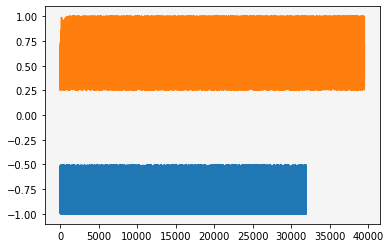

In [0]:
folder=main_folder+"ala2/unbiased/"

all_input=False
only_dist=True
normalize=True

n_dist=45
n_input=n_dist

distA=np.loadtxt(folderA+"INPUTS.A",usecols=range(1,n_dist+1))
distB=np.loadtxt(folderB+"INPUTS.B",usecols=range(1,n_dist+1))   

print(distA.shape)

if normalize:
    # normalize inputs
    Max=np.amax(np.concatenate([distA,distB],axis=0),axis=0)
    Min=np.amin(np.concatenate([distA,distB],axis=0),axis=0)

    Mean=(Max+Min)/2.
    Range=(Max-Min)/2.
    Range[Range<1e-6]=1.

    if all_input:
        #do not normalize angles
        Mean[n_dist:]=0.
        Range[n_dist:]=1.

# create labels
lA=np.zeros_like(distA[:,0])
lB=np.ones_like(distB[:,0])

dist=np.concatenate([distA,distB],axis=0)
dist_label=np.concatenate([lA,lB],axis=0)

p = np.random.permutation(len(dist))
dist, dist_label = dist[p], dist_label[p]

#assign equal weights for testing
w=np.ones_like(dist_label)

train_data=20000
batch_tr=2000
train_labels=ColvarDataset([dist[:train_data],dist_label[:train_data],w[:train_data]])
train_loader_labels=DataLoader(train_labels, batch_size=batch_tr,shuffle=True)

valid_data=20000
batch_val=20000
valid_labels=ColvarDataset([dist[:valid_data],dist_label[:valid_data],w[:valid_data]])
#valid_labels=ColvarDataset([dist[train_data:train_data+test_data],dist_label[train_data:train_data+test_data]])
valid_loader_labels=DataLoader(valid_labels, batch_size=batch_val)

#load validation set from meta
folder_meta=main_folder+"deep-lda/ala2/meta_colvar/"
test_dist=np.loadtxt(folder_meta+"INPUTS_and_COLVARmeta",usecols=range(1,n_dist+1))
phi=np.loadtxt(folder_meta+"INPUTS_and_COLVARmeta",usecols=n_input+2)
psi=np.loadtxt(folder_meta+"INPUTS_and_COLVARmeta",usecols=n_input+3)

test_dist_all = test_dist

test_label=np.full(len(phi),-1)
test_label[(phi<-0.5) & (psi>-1)]=0
test_label[(phi>0.25) & (phi <2) & (psi<1) & (psi>-2.75)]=1

plt.figure()
plt.plot(phi[test_label==0])
plt.plot(phi[test_label==1])

p = np.random.permutation(len(test_dist))
test_dist, test_label = test_dist[p], test_label[p]

test_dist = test_dist [test_label != -1]
test_label = test_label [test_label != -1]

testA=test_dist[test_label==0]
testB=test_dist[test_label==1]

print(testA.shape)
print(testB.shape)

test_data=10000
batch_test=5000

test_meta=ColvarDataset([testA[:test_data],testB[:test_data]])
test_meta_loader=DataLoader(test_meta, batch_size=batch_test)

test_meta_l=ColvarDataset([test_dist[:test_data],test_label[:test_data]])
test_meta_labels=DataLoader(test_meta_l, batch_size=batch_test,shuffle=True)

test_unbiased=ColvarDataset([distA[:test_data],distB[:test_data]])
test_unbiased_loader=DataLoader(test_unbiased, batch_size=batch_test)

### Training

In [0]:
#type
dtype = torch.float32

#parameters
categ = 2
eig_num = 1

# wheter to use CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

n_input=n_dist
n_hidden=5
n_cv=1
nodes=[n_input,30,15,n_hidden]
normalize = True

print("===== NN =====")
model = NN_DeepLDA(nodes)
if normalize:
    model.set_norm(torch.tensor(Mean,dtype=dtype,device=device),torch.tensor(Range,dtype=dtype,device=device))
print("======================")
model.to(device)
if torch.cuda.is_available():
    print("using CUDA acceleration")
    print("========================")

# -- Optimization --
lambdA=0.05
lrate = 0.001
l2_reg = 1e-5
act_reg = 200

num_epochs=50
print_ep=5

#define arrays and values
ep = []
eig = []
eig_t = []
acc = []
acc_t = []
init_epoch = 0
best_result = 0
best_value = 0
best_vectors = 0

#OPTIMIZERS
opt = torch.optim.Adam(model.parameters(), lr=lrate, weight_decay=l2_reg)

#format output
float_formatter = lambda x: "%.6f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})

# grid settings
from matplotlib import pylab
from google.colab import widgets

grid = widgets.Grid(1,4)

print('[{:>3}/{:>3}] {:>10} {:>10} {:>10} {:>10} {:>10}'.format('ep','tot','eig_tr','eig_test','reg'))

# -- Training --
for epoch in range(num_epochs):
    for data in train_loader_labels:
        # =================get data===================
        X,y = data[0].float().to(device),data[1].long().to(device)
        # =================forward====================
        #H,S = model.get_hidden(X,svd=True,svd_eigen=True)
        H = model.get_hidden(X)
        # =================lda loss===================
        lossg, eig_values, max_eig_vector, Sb, Sw = LDAloss_cholesky(H, y)
        model.set_lda(max_eig_vector)  
        s = model.apply_lda(H)
        # =================reg loss===================
        reg_loss = s.pow(2).sum().div( s.size(0) )
        reg_loss_lor = - act_reg / (1+(reg_loss-1).pow(2))
        # =================backprop===================
        opt.zero_grad()
        lossg.backward(retain_graph=True)
        reg_loss_lor.backward()
        opt.step()

    #Compute LDA over entire dataset
    test_eig_values, test_eig_vector = check_LDA_cholesky(valid_loader_labels, model)
    test_eig_values_old, test_eig_vector_old = check_LDA(valid_loader_labels, model)
    model.set_lda(test_eig_vector)    

    #Compute accuracy
    accu_train = classify(valid_loader_labels,train_loader_labels,model)
    accu_test = classify(valid_loader_labels,test_meta_labels,model)
    #save results
    ep.append(epoch+init_epoch+1)
    eig.append(eig_values[-1])
    eig_t.append(test_eig_values[-1])
    acc.append(accu_train)
    acc_t.append(accu_test)
    print
    if (epoch+1)%1 == 0:
        print('[{:3d}/{:3d}] {:10.2f} {:10.2f} {:10.2f} {:10.2G} {:10.2G}'.format
          (init_epoch+epoch+1, init_epoch+num_epochs, eig_values.detach().numpy()[-1], test_eig_values.numpy()[-1], reg_loss, test_eig_vector.numpy())

    if (epoch+1)%print_ep == 0:
        plot_results(testing=True, accuracy=True)

    if eig_values[0] > best_result:
        best_result = test_eig_values[0]
        best_value = test_eig_values
        best_vectors = test_eig_vector
        #torch.save(model, "model_DeepLDA.pt")
        
print("--------------")
print("-- Eigenvalues [Last // Best] --")
print(test_eig_values,best_value)
print("-- LDA Eigenvector [Last // Best]--")
print(test_eig_vector,best_vectors)


#### Analyze hidden space

In [0]:
trA,trB = encode_hidden(valid_loader_labels,model,batch_val,n_hidden,device)

print(trA.shape)

for i in range(trA.shape[1]):
    pylab.figure(figsize=(5, 5))
    pylab.title("h_"+str(i))
    pylab.plot(trA[:,i], c='tab:red', label='trA',alpha=0.7)
    pylab.plot(trB[:,i], c='tab:blue', label='trB',alpha=0.7)
    pylab.legend()

In [0]:
for i in range(trA.shape[1]):
    for j in range(i+1,trA.shape[1]):
        pylab.figure(figsize=(5, 5))
        pylab.title("h_"+str(i)+" vs h_"+str(j))
        pylab.scatter(trA[:,i],trA[:,j], c='tab:red', label='trA',alpha=0.7)
        pylab.scatter(trB[:,i],trB[:,j], c='tab:blue', label='trB',alpha=0.7)
        pylab.legend()

#### Analyze CV

In [0]:
#trA,trB = encode_cv(valid_loader_labels,model,batch_val,n_cv,device)
trA,trB = encode_cv(valid_loader_labels,model,batch_val,1,'cpu')

a = trA[:,0]
b = trB[:,0]

print("==A==")
print(np.mean(a),np.std(a))
print(np.amin(a),np.amax(a))

print("==B==")
print(np.mean(b),np.std(b))
print(np.amin(b),np.amax(b))

### Export model

,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

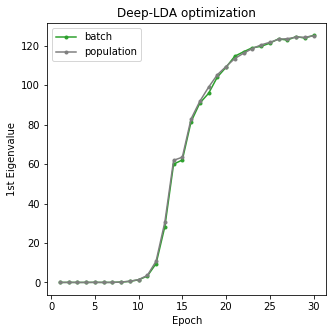

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

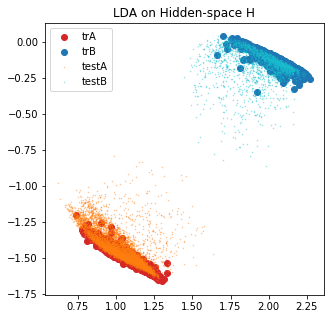

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

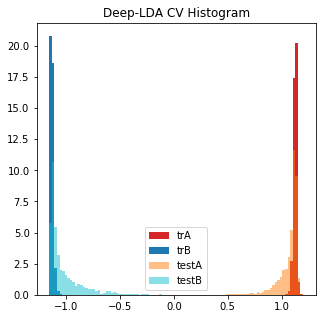

<IPython.core.display.Javascript object>

@@ exported model in:  /content/gdrive/My Drive/autoencoder_cvs/deep-lda/ala2/new_test_lambda/model.pt
45  -->  30 (relu)
30  -->  15 (relu)
15  -->  5 
@@ exported model with hidden components in:  /content/gdrive/My Drive/autoencoder_cvs/deep-lda/ala2/new_test_lambda/model_hidden.pt
@@ checkpoint:  /content/gdrive/My Drive/autoencoder_cvs/deep-lda/ala2/new_test_lambda/checkpoint


In [0]:
# == Set output folder
tr_folder=main_folder+"ala2/"
!mkdir -p "{tr_folder}"

# == Plot and save results == 
grid = widgets.Grid(1,3)
plot_results(save=True,testing=True)

# == Create fake dataloader ==
fake_loader = DataLoader(train_labels, batch_size=1,shuffle=False)
fake_input = next(iter(fake_loader ))[0].float()

# == Export model ==
mod = torch.jit.trace(model, fake_input)
mod.save(tr_folder+"model.pt")
print("@@ exported model in: ",tr_folder+"model.pt" )

# == SAVE LDA COEFFICIENTS ==
f = open(tr_folder+"lda.dat", "w")
f.write(str(model.get_lda().numpy()))
f.close()

# == EXPORT CHECKPOINT ==
torch.save({
            'epoch': num_epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': opt.state_dict(),
            }, tr_folder+"checkpoint")

print("@@ checkpoint: ",tr_folder+"checkpoint" )

## Aldol reaction

#### Load Data

In [0]:
folder=main_folder+"aldol/unbiased/"

normalize=False

n_input=40

# -- Loading and preprocessing --
distA=np.loadtxt(folder+"INPUTS.R",usecols=range(1,n_input+1))
distB=np.loadtxt(folder+"INPUTS.P",usecols=range(1,n_input+1))

print("A",distA.shape)
print("B",distB.shape)

if normalize:
    # normalize inputs
    Max=np.amax(np.concatenate([distA,distB],axis=0),axis=0)
    Min=np.amin(np.concatenate([distA,distB],axis=0),axis=0)

    Mean=(Max+Min)/2.
    Range=(Max-Min)/2.
    Range[Range<1e-6]=1.

# create labels
lA=np.zeros_like(distA[:,0])
lB=np.ones_like(distB[:,0])

dist=np.concatenate([distA,distB],axis=0)
dist_label=np.concatenate([lA,lB],axis=0)

p = np.random.permutation(len(dist))
dist, dist_label = dist[p], dist_label[p]

#assign equal weights for testing
w=np.ones_like(dist_label)

train_data=10000
batch_tr=2000
train_labels=ColvarDataset([dist[:train_data],dist_label[:train_data],w[:train_data]])
train_loader_labels=DataLoader(train_labels, batch_size=batch_tr,shuffle=True)

valid_data=train_data
batch_val=train_data
valid_labels=ColvarDataset([dist[:valid_data],dist_label[:valid_data],w[:valid_data]])
valid_loader_labels=DataLoader(valid_labels, batch_size=batch_val)


A (5001, 40)
B (5001, 40)


#### Training

===== NN =====
40  -->  20 (relu)
20  -->  10 (relu)
10  -->  3 


,,,,


[ ep/tot]     eig_tr   eig_test        reg       corr        var
[  1/  8]      26.24      28.50       0.21     0.0074       0.01 [-0.477106 -0.837665 0.265870]
[  2/  8]      46.99      44.44       0.21     0.0085      0.012 [0.463545 0.854138 -0.235744]
[  3/  8]      60.67      61.94       0.21      0.028      0.012 [-0.455880 -0.864771 0.210580]
[  4/  8]      79.32      80.11       0.21      0.083      0.012 [-0.455948 -0.870940 0.183235]


,,,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

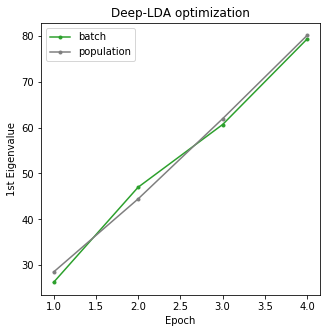

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

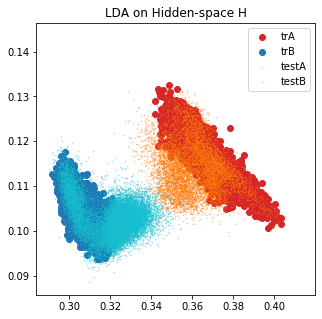

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

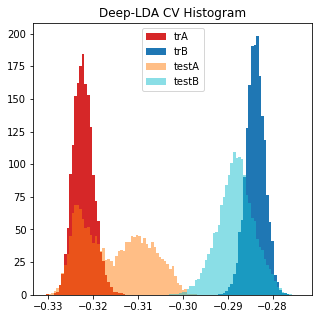

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

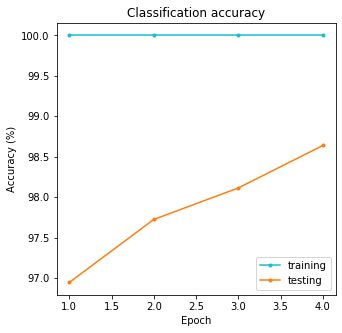

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

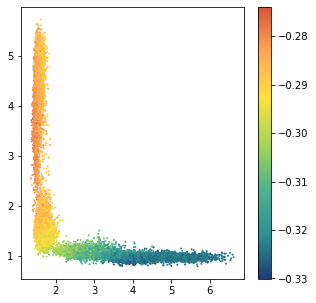

<IPython.core.display.Javascript object>

[  5/  8]     109.76     101.85       0.21       0.14      0.011 [-0.461474 -0.876770 0.135335]
[  6/  8]     130.46     130.97       0.22       0.24      0.011 [-0.467164 -0.881146 0.073074]
[  7/  8]     161.45     164.84       0.22       0.46       0.01 [-0.468609 -0.883117 0.022592]
[  8/  8]     215.73     195.54       0.22       0.66       0.01 [0.465520 0.884827 0.019310]


,,,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

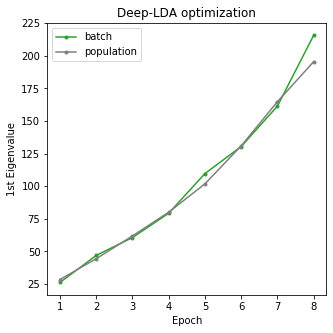

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

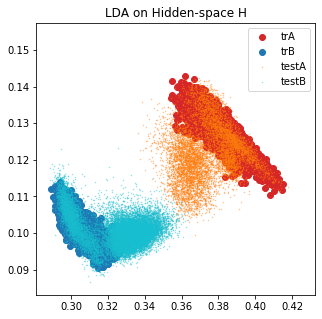

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

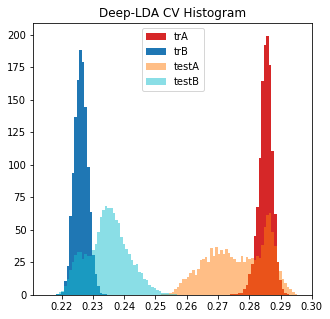

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

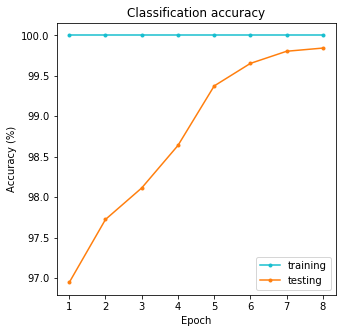

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

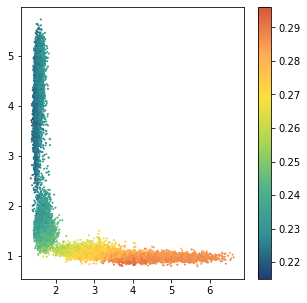

<IPython.core.display.Javascript object>

--------------
-- Eigenvalues [Last // Best] --
tensor([-1.0688e-04, -9.6882e-05,  1.9554e+02]) tensor([-9.7525e-05, -9.1500e-05,  1.3097e+02])
-- LDA Eigenvector [Last // Best]--
tensor([0.4655, 0.8848, 0.0193]) tensor([-0.4672, -0.8811,  0.0731])


In [0]:
#type
dtype = torch.float32

#parameters
categ = 2
eig_num = 1

# wheter to use CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

n_hidden=3
n_cv=1
nodes=[n_input,20,10,n_hidden]
normalize = False

print("===== NN =====")
model = NN_DeepLDA(nodes)
if normalize:
    model.set_norm(torch.tensor(Mean,dtype=dtype,device=device),torch.tensor(Range,dtype=dtype,device=device))
print("======================")
model.to(device)
if torch.cuda.is_available():
    print("using CUDA acceleration")
    print("========================")

# -- Optimization --
lambdA = 0. # 0.025
lrate = 0.00005 #0.0005
l2_reg = 1e-5
act_reg = 0. #80.
cov_reg = 1.
#pca_reg = 0.1 
var_reg = 1.

num_epochs=8
print_ep=4

#define arrays and values
ep = []
eig = []
eig_t = []
acc = []
acc_t = []
init_epoch = 0
best_result = 0

#OPTIMIZERS
opt = torch.optim.Adam(model.parameters(), lr=lrate, weight_decay=l2_reg)

#format output
float_formatter = lambda x: "%.6f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})

# grid settings
from matplotlib import pylab
from google.colab import widgets

grid = widgets.Grid(1,5)

print('[{:>3}/{:>3}] {:>10} {:>10} {:>10} {:>10} {:>10}'.format('ep','tot','eig_tr','eig_test','reg','corr', 'var'))

# -- Training --
for epoch in range(num_epochs):
    for data in train_loader_labels:
        # =================get data===================
        X,y = data[0].float().to(device),data[1].long().to(device)
        # =================forward====================
        #H,S = model.get_hidden(X,svd=True,svd_eigen=True)
        H = model.get_hidden(X)
        # =================lda loss===================
        lossg, eig_values, max_eig_vector, Sb, Sw = LDAloss_cholesky(H, y)
        model.set_lda(max_eig_vector)  
        s = model.apply_lda(H)
        # =================reg loss===================
        #reg_loss = act_reg * H.pow(2).sum().div( X.size(0) )
        reg_loss = H.pow(2).sum().div( H.size(0) )
        #reg_loss = ( s.pow(2).sum().div( s.size(0) ) - 1 ).pow(2)
        reg_loss_lor = - act_reg / (1+(reg_loss-1).pow(2))
        # ==============cross-corr loss================
        decov_loss = cov_reg * DeCov_Loss(H)
        # =============pca loss================
        #pca_loss = - pca_reg * S[-1]
        # =============pca loss================
        H_a = H[torch.nonzero(y == 0).view(-1)]
        H_b = H[torch.nonzero(y == 1).view(-1)]
        var_loss = var_reg * torch.abs((torch.var(H_a) - torch.var(H_b)))
        # =================backprop===================
        opt.zero_grad()
        lossg.backward(retain_graph=True)
        #var_loss.backward()
        #reg_loss.backward()
        reg_loss_lor.backward()
        #decov_loss.backward()
        #pca_loss.backward()
        opt.step()
        
    
    #Compute LDA over entire dataset
    test_eig_values, test_eig_vector = check_LDA_cholesky(valid_loader_labels, model)
    test_eig_values_old, test_eig_vector_old = check_LDA(valid_loader_labels, model)
    #print(test_eig_values[-1].item(),test_eig_values_old[0].item())

    model.set_lda(test_eig_vector)    
    #Compute accuracy
    accu_train = classify(valid_loader_labels,train_loader_labels,model)
    accu_test = classify(valid_loader_labels,test_meta_labels,model)
    #save results
    ep.append(epoch+init_epoch+1)
    eig.append(eig_values[-1])
    eig_t.append(test_eig_values[-1])
    acc.append(accu_train)
    acc_t.append(accu_test)
    print
    if (epoch+1)%1 == 0:
        print('[{:3d}/{:3d}] {:10.2f} {:10.2f} {:10.2f} {:10.2G} {:10.2G}'.format
          (init_epoch+epoch+1, init_epoch+num_epochs, eig_values.detach().numpy()[-1], test_eig_values.numpy()[-1], reg_loss, decov_loss.item()/cov_reg, var_loss.item()/var_reg), test_eig_vector.numpy() )

    if (epoch+1)%print_ep == 0:
        grid = widgets.Grid(1,5)
        plot_results(testing=True, accuracy=True,chem_space=True)
        #print(Sw)

    if eig_values[0] > best_result:
        best_result = test_eig_values[0]
        best_value = test_eig_values
        best_vectors = test_eig_vector
        #torch.save(model, "model_DeepLDA.pt")
        
print("--------------")
print("-- Eigenvalues [Last // Best] --")
print(test_eig_values,best_value)
print("-- LDA Eigenvector [Last // Best]--")
print(test_eig_vector,best_vectors)

In [0]:
#torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(),'optimizer_state_dict': opt.state_dict(), 'loss': lossg}, folder+"model_manyi_testNRB..pt")
model_file = main_folder + "Manyi/model_manyi_testNRB..pt"

model2 = NN_DeepLDA(nodes)
model2.set_lda(torch.zeros(n_hidden)) 
checkpoint = torch.load(model_file)

model2.load_state_dict(checkpoint['model_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

40  -->  30 (relu)
30  -->  20 (relu)
20  -->  10 (relu)
10  -->  5 


s' = A * s + B
A:  33.887813725333245
B:  -8.665374789715635
s'' = s + s**3
MEAN:  1.0000000000000016 -0.9999999999999994
STD:  0.07190945350533062 0.07110663895214332


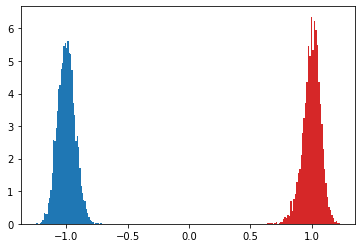

In [0]:
trA,trB = encode_cv(valid_loader_labels ,model,batch_val,n_cv,device)

a = trA[:,0]
b = trB[:,0]

ma,mb = np.mean(a),np.mean(b)

range_s = np.abs(ma - mb ) 

a = a*2./range_s
b = b*2./range_s

shift = -1 - np.amin([np.mean(a),np.mean(b)])

A=2./range_s
B=shift

a = a + shift
b = b + shift 
#a = a+a**3
#b = b+b**3

print("==============")
print("s' = A * s + B")
print("A: ",2./range_s)
print("B: ",shift)
print("==============")
print("s'' = s + s**3")
print("==============")
print("MEAN: ", np.mean(a),np.mean(b))
print("STD: ", np.std(a),np.std(b))
print("==============")
p1 = pylab.hist(a, bins=50, ls='dashed', alpha = 1., lw=2, color='tab:red', label='trA',density=True)
p2 = pylab.hist(b, bins=50, ls='dashed', alpha = 1., lw=2, color='tab:blue', label='trb',density=True)

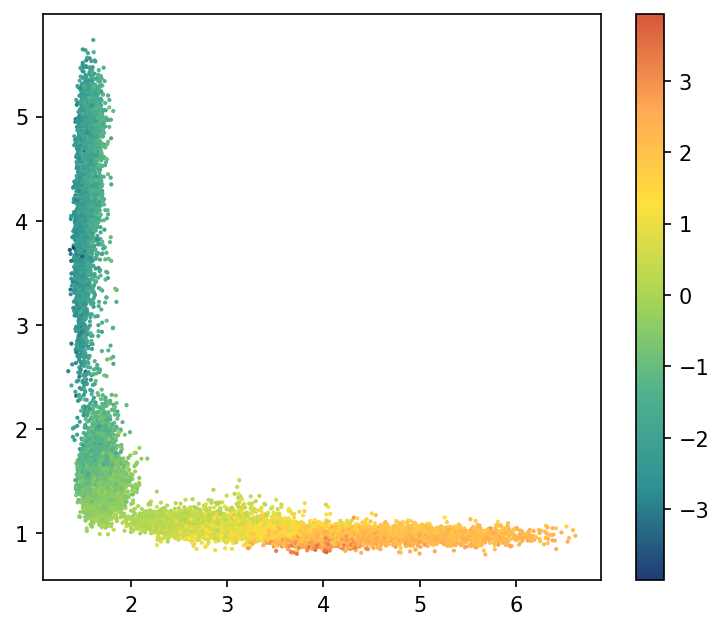

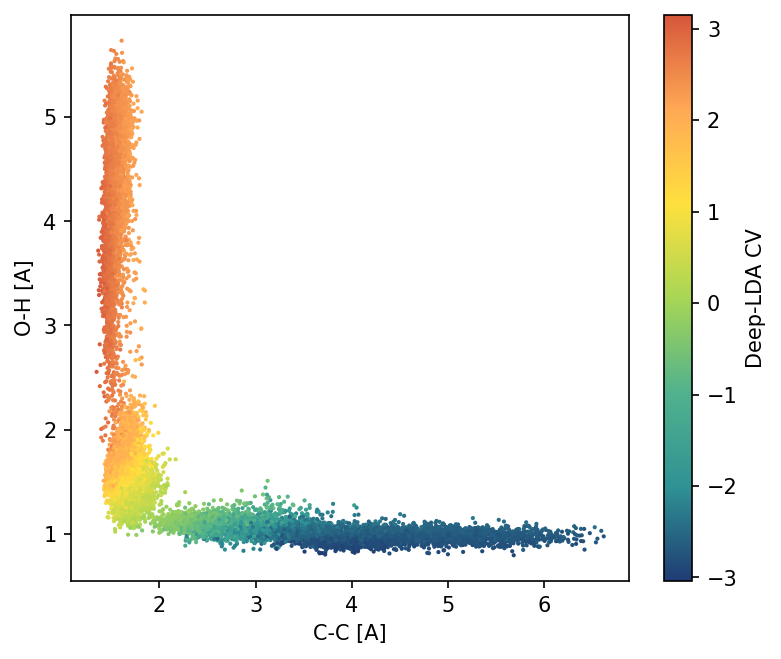

In [0]:
s,l = encode_cv_all(test_meta_ord_labels,model,batch_test,n_cv,device)
s = s[:,0]

s = A*s+B
s2 = s + np.power(s,3)

x = de_cc
y = de_oh1

x = x[:len(s)]
y = y[:len(s)]

pylab.figure(figsize=(6,5),dpi=150)
scat = pylab.scatter(x,y,c=s2,cmap=cm_fessa,s=1.)
pylab.colorbar(scat)

pylab.figure(figsize=(6,5),dpi=150)
s_cube = cv_cube[::ev]
s_cube = s_cube[:len(s)]
scat = pylab.scatter(x,y,c=-s_cube,cmap=cm_fessa,s=1.)#,vmin=-2.2, vmax=0)
pylab.xlabel("C-C [A]")
pylab.ylabel("O-H [A]")
cbar = pylab.colorbar(scat)
cbar.set_label("Deep-LDA CV")

#### Export model

In [0]:
# == Set output folder
tr_folder=main_folder+"aldol/"
!mkdir -p "{tr_folder}"

# == Plot and save results == 
grid = widgets.Grid(1,5)
plot_results(save=True,testing=True,accuracy=True,chem_space=True)

# == Create fake dataloader ==
fake_loader = DataLoader(train_labels, batch_size=1,shuffle=False)
fake_input = next(iter(fake_loader ))[0].float()

# == Export model ==
mod = torch.jit.trace(model, fake_input)
mod.save(tr_folder+"model.pt")
print("@@ exported model in: ",tr_folder+"model.pt" )

# == SAVE LDA COEFFICIENTS ==
f = open(tr_folder+"lda.dat", "w")
f.write(str(model.get_lda().numpy()))
f.close()

# == EXPORT CHECKPOINT ==
torch.save({
            'epoch': num_epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': opt.state_dict(),
            }, tr_folder+"checkpoint")

print("@@ checkpoint: ",tr_folder+"checkpoint" )